In [1]:
from __future__ import annotations

from typing import Callable

import matplotlib.pyplot as plt

%env KERAS_BACKEND=torch

import keras
from keras import layers
import keras_tuner

env: KERAS_BACKEND=torch


In [2]:
# Move to project root
from pathlib import Path
import os

if not Path("./checkpoints").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "checkpoints").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./checkpoints").is_dir()

In [3]:
from src import kernels, convolutions
from src.models.old import gangoly_cifar
from src import load_data

In [4]:
from typing import NamedTuple


class TrialWrapper(NamedTuple):
    trial: keras_tuner.engine.trial.Trial
    trial_id: str
    hyperparameters: keras_tuner.HyperParameters
    metrics: dict[str, float]
    score: float
    best_step: int
    loader: ModelLoader = None

    @classmethod
    def from_trial(
            cls, trial: keras_tuner.engine.trial.Trial, model_loader: ModelLoader = None
    ):
        metrics = {
            name: hist.get_best_value() for name, hist in trial.metrics.metrics.items()
        }
        return cls(
            trial,
            trial.trial_id,
            trial.hyperparameters,
            metrics,
            trial.score,
            trial.best_step,
            model_loader,
        )

    def load_model(self) -> keras.Model:
        assert self.loader and self.trial
        return self.loader.tuner.load_model(self.trial)

In [44]:
class ModelLoader:
    def __init__(
            self,
            project_name: str,
            hypermodel: Callable[[keras_tuner.HyperParameters], keras.Model],
            tuner_kind="grid",
    ):
        if tuner_kind == "grid":
            tuner_cls = keras_tuner.GridSearch
        else:
            raise ValueError(f"Unknown {tuner_kind=}")
        self.tuner: keras_tuner.Tuner = tuner_cls(
            hypermodel=hypermodel,
            objective="val_accuracy",
            max_trials=0,
            overwrite=False,
            directory="checkpoints",
            project_name=project_name,
        )
        self.trials = self.tuner.oracle.get_best_trials(999999999)
        print(f"Loaded {len(self.trials)} trials.")
        self.all_params = set()

        for trial in self.trials:
            self.all_params.update(trial.hyperparameters.values)

    @staticmethod
    def nonconflicting(query_params: dict, trial_params: dict):
        qp_set, tp_set = set(query_params), set(trial_params)
        if qp_set.difference(tp_set):
            return False
        for key in tp_set.intersection(query_params):
            if trial_params[key] != query_params[key]:
                return False
        return True

    def find(self, query_params: dict) -> TrialWrapper:
        unknown_keys = set(query_params).difference(self.all_params)
        assert not unknown_keys, f"{unknown_keys=}"
        for trial in self.trials:
            if self.nonconflicting(query_params, trial.hyperparameters.values):
                return TrialWrapper.from_trial(trial, self)
        raise ValueError(f"{query_params=} are conflicting or were not tested")

In [74]:
basic_loader = ModelLoader("gangoly_cifar", gangoly_cifar.gangoly_cifar(3, 10))

Reloading Tuner from checkpoints/gangoly_cifar/tuner0.json
Loaded 18 trials.


In [7]:
basic_loader.tuner.results_summary()

Results summary
Results in checkpoints/gangoly_cifar
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0000 summary
Hyperparameters:
init_kind: normal
quadratic-pooling: True
quadratic-pool-kernel: quadratic-iso
quadratic-pool-softpool: False
quadratic-pool-size: 3
Score: 0.7190666794776917

Trial 0001 summary
Hyperparameters:
init_kind: normal
quadratic-pooling: True
quadratic-pool-kernel: quadratic-iso
quadratic-pool-softpool: False
quadratic-pool-size: 5
Score: 0.7108222047487894

Trial 0002 summary
Hyperparameters:
init_kind: normal
quadratic-pooling: True
quadratic-pool-kernel: quadratic-iso
quadratic-pool-softpool: True
quadratic-pool-size: 3
quadratic-pool-softpool-temp: 1.0
Score: 0.707444449265798

Trial 0004 summary
Hyperparameters:
init_kind: normal
quadratic-pooling: True
quadratic-pool-kernel: quadratic-iso
quadratic-pool-softpool: True
quadratic-pool-size: 3
quadratic-pool-softpool-temp: 16.0
Score: 0.704533318678538

Trial 0003 summary
Hyperpa

In [8]:
qt = basic_loader.find({"quadratic-pool-kernel": "quadratic-multi"})
print(qt.metrics)
qm = qt.load_model()

{'accuracy': np.float64(0.8591809471448263), 'loss': np.float64(0.45946698387463886), 'top3': np.float64(0.9778285622596741), 'val_accuracy': np.float64(0.6835777759552002), 'val_loss': np.float64(0.9213109215100607), 'val_top3': np.float64(0.9108222126960754)}


In [9]:
qm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (TorchModuleWrapper)    │ (256, 3, 32, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-32 (Sequential)           │ (256, 32, 32, 32)      │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-multi-pool-1          │ (256, 32, 30, 30)      │            96 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-128 (Sequential)          │ (256, 128, 30, 30)     │       185,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-multi-pool-2          │ (256, 128, 28, 28)     │           384 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (256, 128, 28, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-256 (Sequential)          │ (256, 256, 28, 28)     │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-multi-pool-3          │ (256, 256, 26, 26)     │           768 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_block (Sequential)           │ (256, 10)              │   177,740,298 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,823,178 (682.16 MB)

 Trainable params: 178,822,346 (682.15 MB)

 Non-trainable params: 832 (3.25 KB)

In [10]:
cifar10 = load_data.cifar10()
cifar10

Dataset(x_train=(50000, 3, 32, 32), x_test=(10000, 3, 32, 32), y_train=(50000,), y_test=(10000,))

In [11]:
print(
    "train",
    qm.evaluate(cifar10.x_train, cifar10.y_train, batch_size=2 ** 8, return_dict=True),
)
print()
print(
    "test",
    qm.evaluate(cifar10.x_test, cifar10.y_test, batch_size=2 ** 8, return_dict=True),
)

196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.9153 - loss: 0.3434 - top3: 0.9861
train {'accuracy': 0.8553199768066406, 'loss': 0.4915544092655182, 'top3': 0.967199981212616}

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.6873 - loss: 0.9196 - top3: 0.9149
test {'accuracy': 0.6866999864578247, 'loss': 0.9229629039764404, 'top3': 0.9143000245094299}


In [12]:
qtiso = basic_loader.find({"quadratic-pool-kernel": "quadratic-iso"})
print(qtiso.metrics)
qmiso = qtiso.load_model()

{'accuracy': np.float64(0.8364190459251404), 'loss': np.float64(0.49726856748263043), 'top3': np.float64(0.9717714190483093), 'val_accuracy': np.float64(0.7190666794776917), 'val_loss': np.float64(0.8140487670898438), 'val_top3': np.float64(0.926288902759552)}


In [13]:
print(
    "train",
    qm.evaluate(
        cifar10.x_train,
        cifar10.y_train,
        batch_size=2 ** 8,
        return_dict=True,
        verbose=False,
    ),
)
print(
    "test",
    qm.evaluate(
        cifar10.x_test, cifar10.y_test, batch_size=2 ** 8, return_dict=True, verbose=False
    ),
)

train {'accuracy': 0.8553199768066406, 'loss': 0.4915544092655182, 'top3': 0.967199981212616}

test {'accuracy': 0.6866999864578247, 'loss': 0.9229629039764404, 'top3': 0.9143000245094299}


In [45]:
long_loader = ModelLoader(
    "gangoly_cifar_longer", gangoly_cifar.gangoly_cifar(3, 10, force_temp=None)
)
soft_loader = ModelLoader(
    "gangoly_cifar_longer_soft", gangoly_cifar.gangoly_cifar(3, 10, force_temp=0.01)
)

Reloading Tuner from checkpoints/gangoly_cifar_longer/tuner0.json
Loaded 4 trials.
Reloading Tuner from checkpoints/gangoly_cifar_longer_soft/tuner0.json
Loaded 3 trials.


In [18]:
best_long = long_loader.find({})
print(best_long.metrics)
print(best_long.hyperparameters.values)
m_blong = best_long.load_model()

{'accuracy': np.float64(0.9928285678227743), 'loss': np.float64(0.05864877253770828), 'top3': np.float64(0.999914288520813), 'val_accuracy': np.float64(0.7530666589736938), 'val_loss': np.float64(0.8585668603579203), 'val_top3': np.float64(0.937666654586792)}
{'quadratic-pooling': True, 'quadratic-pool-kernel': 'quadratic-iso', 'quadratic-pool-size': 3, 'init_kind': 'normal'}


In [16]:
print(
    "train",
    m_blong.evaluate(
        cifar10.x_train,
        cifar10.y_train,
        batch_size=2 ** 8,
        return_dict=True,
        verbose=False,
    ),
)
print(
    "test",
    m_blong.evaluate(
        cifar10.x_test, cifar10.y_test, batch_size=2 ** 8, return_dict=True, verbose=False
    ),
)

train {'accuracy': 0.9282400012016296, 'loss': 0.26179227232933044, 'top3': 0.982420027256012}
test {'accuracy': 0.7530999779701233, 'loss': 0.8670251965522766, 'top3': 0.9415000081062317}


In [17]:
m_blong.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (TorchModuleWrapper)    │ (256, 3, 32, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-32 (Sequential)           │ (256, 32, 32, 32)      │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-iso-pool-1            │ (256, 32, 30, 30)      │            32 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-128 (Sequential)          │ (256, 128, 30, 30)     │       185,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-iso-pool-2            │ (256, 128, 28, 28)     │           128 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (256, 128, 28, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-256 (Sequential)          │ (256, 256, 28, 28)     │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quadratic-iso-pool-3            │ (256, 256, 26, 26)     │           256 │
│ (TorchModuleWrapper)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_block (Sequential)           │ (256, 10)              │   177,740,298 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,822,348 (682.15 MB)

 Trainable params: 178,821,514 (682.15 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 2 (8.00 B)

In [117]:
def plot_main_three(loader: ModelLoader, title="", mods: dict = None):
    if mods is None:
        mods = {}
    model_types = (
        {"quadratic-pool-kernel": "quadratic-iso", "quadratic-pooling": True, **mods},
        {"quadratic-pool-kernel": "quadratic-multi", "quadratic-pooling": True, **mods},
        {"quadratic-pooling": False},
    )
    train_accs = []
    val_accs = []
    test_accs = []
    names = ["Isotropic", "Multivariate", "Std maxpool"]
    mod_names = []
    for name, params in zip(names, model_types):
        try:
            long_trial = loader.find(params)
        except ValueError:
            continue
        train_accs.append(long_trial.metrics["accuracy"])
        val_accs.append(long_trial.metrics["val_accuracy"])
        test_acc = long_trial.load_model().evaluate(
            cifar10.x_test,
            cifar10.y_test,
            batch_size=2 ** 8,
            return_dict=True,
            verbose=False,
        )["accuracy"]
        mod_names.append(f"{name}: {test_acc:.1%} test")
        test_accs.append(test_acc)
    plt.bar(mod_names, train_accs, label="Train accuracy", width=0.5, alpha=0.8)
    plt.bar(mod_names, val_accs, label="Validation accuracy", width=0.45)
    plt.bar(mod_names, test_accs, label="Test accuracy", width=0.4)
    plt.tight_layout()
    plt.legend()
    plt.ylim(0, 1)
    plt.title(title)
    plt.show()

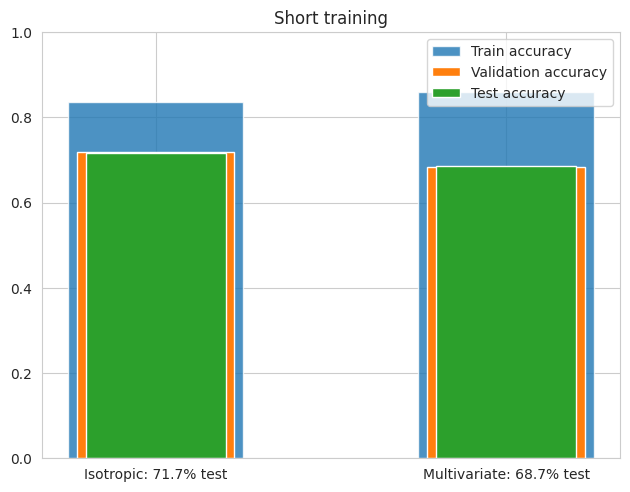

In [118]:
plot_main_three(basic_loader, "Short training")

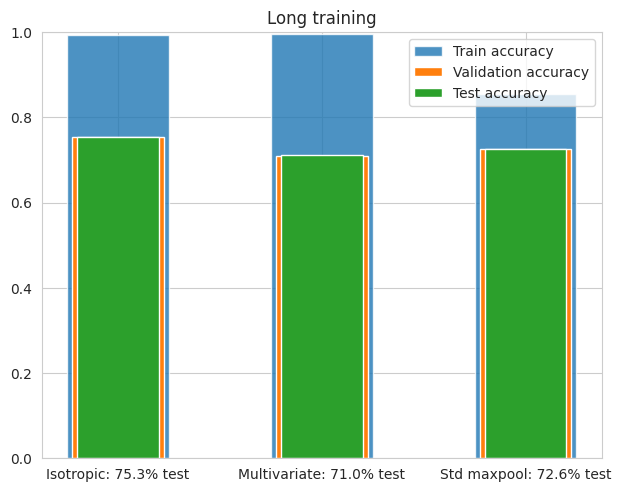

In [119]:
plot_main_three(long_loader, "Long training")

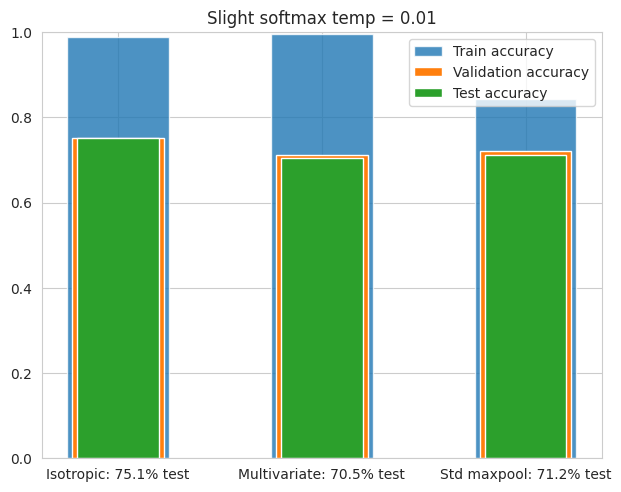

In [120]:
plot_main_three(soft_loader, "Slight softmax temp = 0.01")

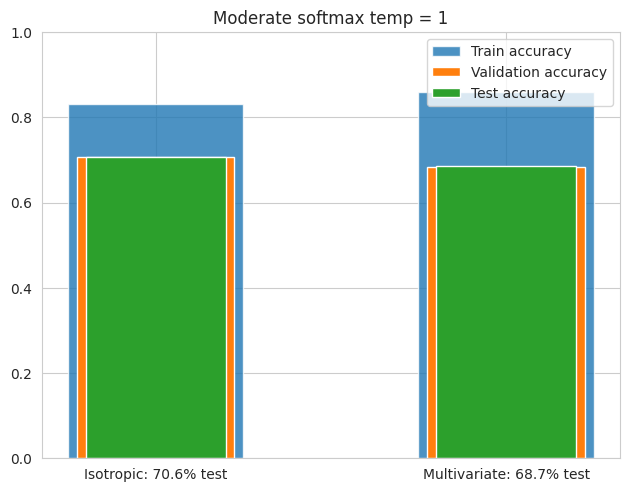

In [121]:
plot_main_three(
    basic_loader, "Moderate softmax temp = 1", mods={"quadratic-pool-softpool-temp": 1}
)

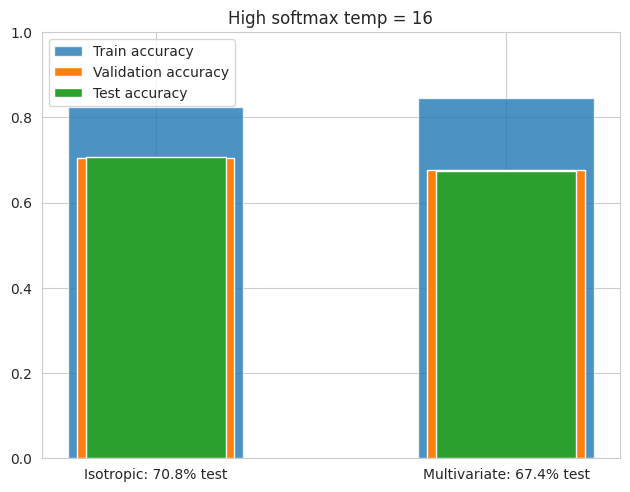

In [122]:
plot_main_three(
    basic_loader, "High softmax temp = 16", mods={"quadratic-pool-softpool-temp": 16}
)

In [83]:
def extract_quadratic_kernels(
        model: keras.Sequential,
) -> list[kernels.QuadraticKernelIso2D | kernels.QuadraticKernelCholesky2D]:
    ks = []
    for layer in model.layers:
        if not isinstance(layer, layers.TorchModuleWrapper):
            continue

        mod = layer.module
        if not isinstance(mod, convolutions.GenericConv2D):
            continue

        ks.append(mod.kernel)

    return ks

In [84]:
q_kernels = extract_quadratic_kernels(
    soft_loader.find({"quadratic-pool-kernel": "quadratic-multi"}).load_model()
)
q_kernels

[QuadraticKernelMulti2D(
   1, 32, kernel_size=3
   (covs): LearnedCovs2D(1, 32)
 ),
 QuadraticKernelMulti2D(
   1, 128, kernel_size=3
   (covs): LearnedCovs2D(1, 128)
 ),
 QuadraticKernelMulti2D(
   1, 256, kernel_size=3
   (covs): LearnedCovs2D(1, 256)
 )]

In [101]:
def plot_quadratic_kernels(
        ks: list[kernels.QuadraticKernelIso2D | kernels.QuadraticKernelCholesky2D],
        title: str = "",
):
    if isinstance(ks[0], kernels.QuadraticKernelCholesky2D):
        fig, axss = plt.subplots(len(ks), 3, layout="compressed")
        for k, axs in zip(ks, axss):
            axs[0].set_title("$\\rho$")
            axs[0].set_xlim(-1, 1)
            axs[0].hist(k.covs.corr_param.tanh().numpy(force=True))

            axs[1].set_title("$\\ log(\\sigma_0)$")
            axs[1].hist(k.covs.log_stds[0].numpy(force=True))

            axs[2].set_title("$\\ log(\\sigma_1)$")
            axs[2].hist(k.covs.log_stds[1].numpy(force=True))
    else:
        fig, axs = plt.subplots(len(ks), layout="compressed")
        for k, ax in zip(ks, axs):
            ax.set_title("$\\ log(\\sigma)$")
            ax.hist(k.std_param.numpy(force=True))
    fig.suptitle(title)

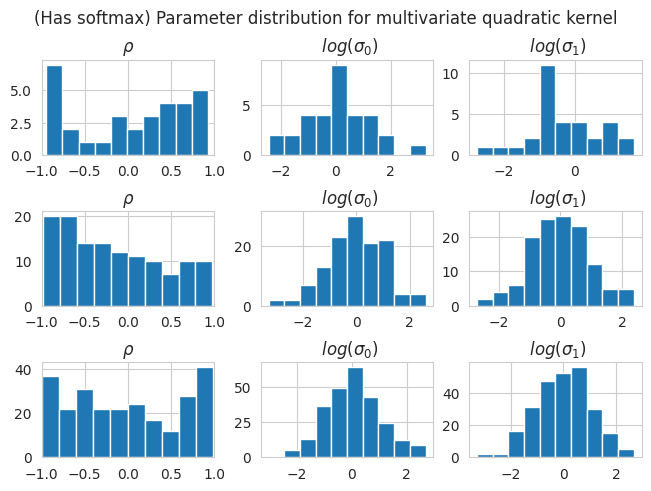

In [103]:
plot_quadratic_kernels(
    q_kernels, "(Has softmax) Parameter distribution for multivariate quadratic kernel"
)

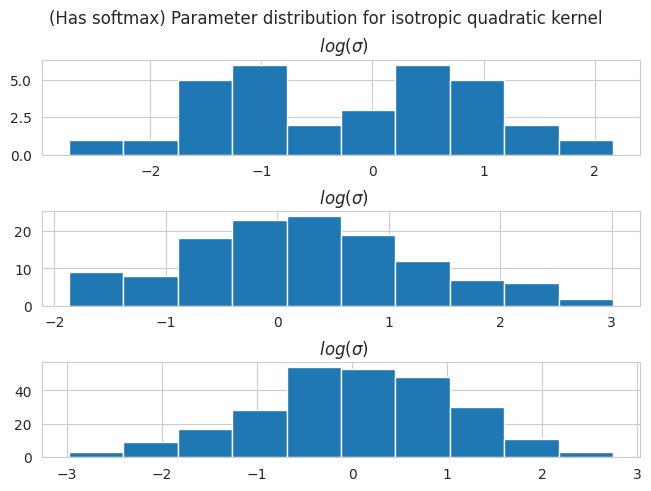

In [104]:
qk_iso = extract_quadratic_kernels(
    soft_loader.find({"quadratic-pool-kernel": "quadratic-iso"}).load_model()
)
plot_quadratic_kernels(
    qk_iso, "(Has softmax) Parameter distribution for isotropic quadratic kernel"
)

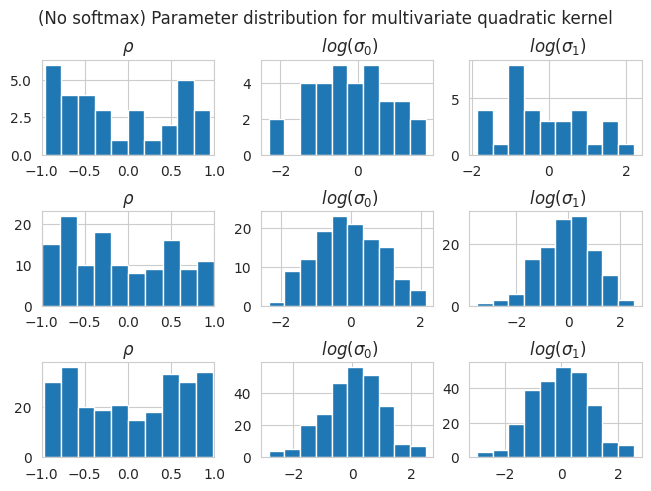

In [113]:
qk_h_m = extract_quadratic_kernels(
    long_loader.find(
        {"quadratic-pool-kernel": "quadratic-multi", "quadratic-pooling": True}
    ).load_model()
)
plot_quadratic_kernels(
    qk_h_m, "(No softmax) Parameter distribution for multivariate quadratic kernel"
)

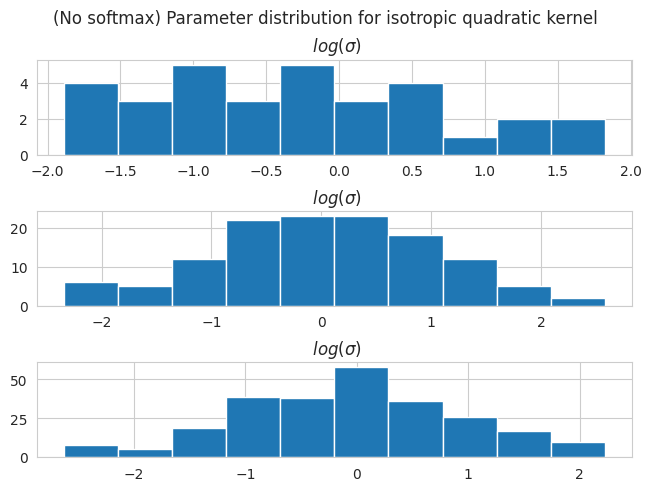

In [114]:
qk_h_i = extract_quadratic_kernels(
    long_loader.find(
        {"quadratic-pool-kernel": "quadratic-iso", "quadratic-pooling": True}
    ).load_model()
)
plot_quadratic_kernels(
    qk_h_i, "(No softmax) Parameter distribution for isotropic quadratic kernel"
)

In [107]:
long_loader.find({"quadratic-pool-kernel": "quadratic-multi"}).load_model().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (TorchModuleWrapper)    │ (256, 3, 32, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-32 (Sequential)           │ (256, 32, 32, 32)      │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (256, 32, 16, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-128 (Sequential)          │ (256, 128, 16, 16)     │       185,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (256, 128, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (256, 128, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convs-256 (Sequential)          │ (256, 256, 8, 8)       │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (256, 256, 7, 7)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_block (Sequential)           │ (256, 10)              │    13,376,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,457,642 (55.15 MB)

 Trainable params: 14,456,810 (55.15 MB)

 Non-trainable params: 832 (3.25 KB)